# AID 1706

This notebook looks at a drug screen against SARS-CoV1 Papain-like protease (PL-pro). PL-pro is essential for virus assembly. The screen was carried out at * by \* in \*. The assay is a QFRET-based measure of protease activity inhibition in response to the test compounds.  The test compounds are from the * screening library. In \*.ipynb we used http requests to download this data from the pubchem database and saved the 29 MB output into ```AID_1706.csv```.

This notebook explores the dataset by calculating some physical-chemistry properties of the screening set, and looks at parralelizing   the calucualtions. After that, we'll look at sub-structure searching and fingerprints. The functions should be reusable in future machine learning tasks.

#### Breakdown of dataset
```PUBCHEM_RESULT_TAG```: 

```PUBCHEM_SID```: Substance ID - useful for mixtures

```PUBCHEM_CID```: Compound ID - applies if a single compound was tested

```PUBCHEM_ACTIVITY_OUTCOME```: Pubchem assigned labels: ```Inactive``` or ```Active```

```PUBCHEM_ACTIVITY_SCORE```: Pubchem normalized assay result

```Inhibition```: Assay result (range: -500:100)

```smiles```: Compound structure description

In [1]:
import pandas as pd

df = pd.read_csv('AID_1706.csv', index_col=0)

print(f'Number of datapoints:\t{len(df)}')
df.head()

Number of datapoints:	290893


,PUBCHEM_RESULT_TAG,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,Inhibition,smiles
0,445,842574,644842,Inactive,6.0,4.94,COC(=O)C1=CC=CC=C1NC(=O)C2CC(=O)N(C2)C3=CC=C(C...
1,660,842798,645071,Inactive,0.0,0.13,CCOC(=O)CNC(=O)CSC1=NN=NN1C2=C(C=CC(=C2)C)C
2,821,842962,645240,Inactive,0.0,-7.40,C1CN(CCC1(C2=CN=CC=C2)O)C(=O)C3=CC=CC=C3F
3,1611,843768,646070,Inactive,0.0,-0.40,CC12CC3(CN(C1)C(N(C2)C3)C4=CC(=C(C=C4)O)OC)C
4,1773,843933,646239,Inactive,3.0,2.74,C1CC(OC1)CN(CC2=CC3=CC4=C(C=C3NC2=O)OCCO4)S(=O...


# The metric
To try to understand the difference between ```PUBCHEM_ACTIVITY_SCORE``` and ```Inhibition``` and their relationship with the ```PUBCHEM_ACTIVITY_OUTCOME```, I've plotted the metrics against eachother and colored the active compounds. It looks like the Pubchem activity score can be described with  
$$Pubchem Activity Score = max(0,m \times Inhibition)$$

where $m$ is the gradient of the line where $x >0$. A simple way to fit a curve or line to a set of datapoints is with [```scipy.optimize.curve_fit```](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html), which uses [nonlinear least squares](https://en.wikipedia.org/wiki/Non-linear_least_squares) to as the fitting algorithm. ```curve_fit``` takes the function that we need to fit parameters to, $x$ and $y$. It returns a ```numpy``` array of parameters (just one in this case) and a covarience matrix.

PUBCHEM_ACTIVITY_SCORE = max(0, 1.143 * Inhibition)
error??


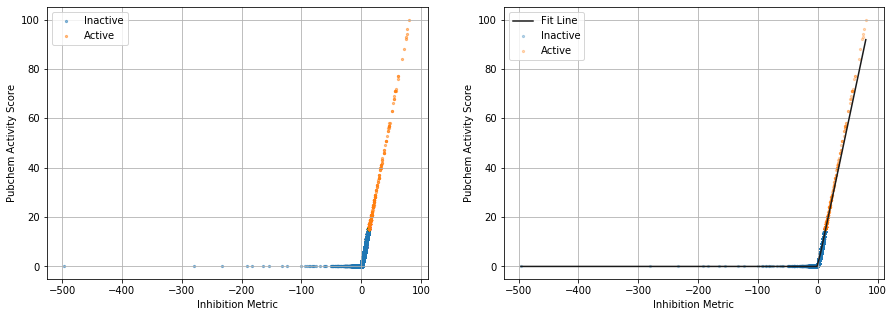

In [2]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

####### curve fitting ########

def curve(x,m):
    return np.maximum(m*x, 0)

param, covariance = curve_fit(curve, df['Inhibition'], df['PUBCHEM_ACTIVITY_SCORE'])

print(f'PUBCHEM_ACTIVITY_SCORE = max(0, {round(param.item(), 3)} * Inhibition)')
print(f'error??')

###### plotting #########

inactive = df.loc[df['PUBCHEM_ACTIVITY_OUTCOME']=='Inactive']
active = df.loc[df['PUBCHEM_ACTIVITY_OUTCOME']=='Active']


fig, ((ax1, ax2)) = plt.subplots(1,2, figsize = (15,5))


ax1.scatter(inactive['Inhibition'], inactive['PUBCHEM_ACTIVITY_SCORE'], s=5, alpha = 0.5)
ax1.scatter(active['Inhibition'], active['PUBCHEM_ACTIVITY_SCORE'],s=5,alpha = 0.5)
ax1.legend(['Inactive','Active'])
ax1.set_xlabel('Inhibition Metric')
ax1.set_ylabel('Pubchem Activity Score')
ax1.grid()


x = np.linspace(df['Inhibition'].min(), df['Inhibition'].max(), 100)

ax2.scatter(inactive['Inhibition'], inactive['PUBCHEM_ACTIVITY_SCORE'], s=5, alpha = 0.3)
ax2.scatter(active['Inhibition'], active['PUBCHEM_ACTIVITY_SCORE'],s=5,alpha = 0.3)
ax2.plot(x, curve(x, param), color = '0.1')

ax2.legend(['Fit Line','Inactive','Active'])
ax2.set_xlabel('Inhibition Metric')
ax2.set_ylabel('Pubchem Activity Score')
ax2.grid()

plt.show()

# talk about reading smiles

,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,Structure
90,Inactive,0.0,
431,Inactive,1.0,
103,Inactive,0.0,
267,Inactive,0.0,
70,Inactive,2.0,

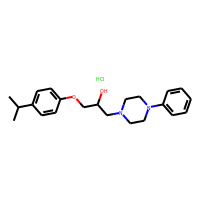
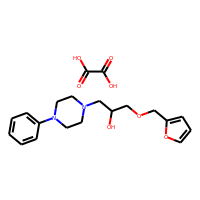
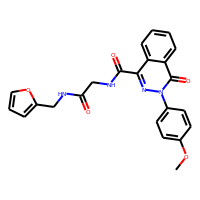
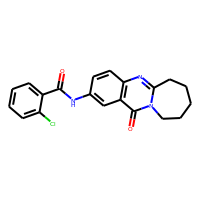
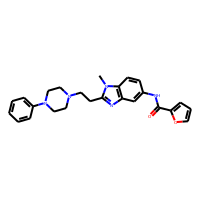

In [3]:
from rdkit import Chem
from rdkit.Chem import PandasTools

df_sample = df.sample(1000)
PandasTools.AddMoleculeColumnToFrame(df_sample, 
                                     smilesCol = 'smiles',
                                     molCol='Structure')

df_sample[['PUBCHEM_ACTIVITY_OUTCOME', 'PUBCHEM_ACTIVITY_SCORE','Structure']][0:5]

# Talk about lipinski

In [4]:
from rdkit.Chem import Crippen, AllChem

def PhysChemFeatures(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    dictionary = {'MolWT':AllChem.CalcExactMolWt(mol),
                  'LogP':Chem.Crippen.MolLogP(mol),
                  'HBondDonors': AllChem.CalcNumLipinskiHBD(mol),
                  'HBondAcceptors': AllChem.CalcNumLipinskiHBA(mol)}
    
    return pd.Series(dictionary)

df.sample(1000)['smiles'].apply(PhysChemFeatures).head()

,MolWT,LogP,HBondDonors,HBondAcceptors
955,333.995304,2.86760,1.0,5.0
604,350.163043,3.61280,1.0,5.0
444,416.048403,2.41200,1.0,7.0
679,381.014660,2.60739,2.0,5.0
169,440.194737,2.44720,1.0,8.0


## Parralelism
Functions can be run in parralel if the calculations are independent of each other, therefore we can calculate physical chemistry descriptors for each molecule in parralel. In this sectin we'll compare a few methods of parralelism with non-parralel counterparts. 

A useful command for timing a function is the ```%%timeit``` magic command. When executed in a cell, it runs the cell seven times and prints the mean time of completion and the standard deviation. 


In [6]:
%%timeit
df.sample(1000)['smiles'].apply(PhysChemFeatures)

1.06 s ± 49.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Applying a functions to a pandas series is an example of serial execution - one operation after another. It essentially wraps a loop that performs the function on each value one at a time. 

Our two options for speeding up our physical chemistry calculations  are **multi-threading** and **multi-processing**. 

#### Multithreading
Multithreading is efficient task scheduling. It's especially efficient for I/O (input/output) bound programs, which have to wait for responses from external resources (e.g. sending http requests). In this case, once the first request is sent and waiting for a response, the second request can be sent. 

As far is I know, our ```PhysChemFeatures``` function is not I/O bound, but is CPU-bound - limited by the speed of the processor. I've written a function below that uses multithreading for comparison. It uses the ```concrrent``` module from the standard python library. It uses the context manager to start a 'thread pool executor' and automatically close it down after.  The thread pool executor has jobs submitted to it using the ```map``` function, and then manages their execution. The ```results``` object is a generator, which is unpacked using ```list``` before being packaged into a ```DataFrame```. 

#### Multiprocessing
Multiprocessing is parralelism. CPUs are allocated to a  resource Pool, which can be used to allocate CPU time. At runtime, the job is divided between the CPUs and excuted in parralel. Multiprocessing is suitable for CPU-bound processes, like our ```PhysChemFeatures``` function presumably is. The disadvantage of multiprocessing is the overhead in distrubuting jobs between CPUs, may not pay off with a small number of jobs.

The ```multiprocess```  function I've written below is syntacticly similar to the ```multithread``` function, except it maps jobs to  ```multiprocessing.Pool``` rather than ```concurrent.futures.ThreadPoolExecutor```. It also takes the argmuent ```processes``` which I've set to my CPU count - 1, leaving me with one whilst it works.

#### Testing
I've pitted these two functions agaist eachother below to see how well they scale with increasing dataset size.

100%|██████████| 5/5 [01:24<00:00, 16.81s/it]


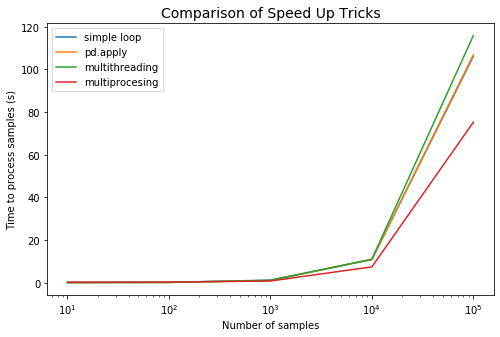

In [7]:
from concurrent.futures import ThreadPoolExecutor
from multiprocessing import Pool, cpu_count
import time
from tqdm import tqdm

def simple_loop(smiles, fn):
    return pd.DataFrame([fn(i) for i in smiles])

def pandas_apply(smiles, fn):
    return smiles.apply(fn)

def multithread(smiles, fn):
    with ThreadPoolExecutor(max_workers=3) as executor:
        results = executor.map(fn, smiles)
    return pd.DataFrame(list(results))

def multiprocess(smiles, fn):
    with Pool(processes = (cpu_count() - 1)) as pool:
        results = pool.map(fn, smiles)
    pool.join()
    return pd.DataFrame(results)

def test_speed(fn, ns):
    time_elapsed = []
    for i in tqdm(ns):
        start = time.time()
        _ = fn(df['smiles'].sample(i), PhysChemFeatures)
        finish = time.time()
        elapsed = finish-start
        time_elapsed.append(elapsed)
    return time_elapsed

sample_sizes = [1*(10**i) for i in range(1, 6)]

simple_loop_times = test_speed(simple_loop, sample_sizes)
applied_times = test_speed(pandas_apply, sample_sizes)
multithread_times = test_speed(multithread, sample_sizes)
multiprocess_times = test_speed(multiprocess, sample_sizes)

plt.figure(figsize = (8,5))
plt.plot(sample_sizes, simple_loop_times)
plt.plot(sample_sizes, applied_times)
plt.plot(sample_sizes, multithread_times)
plt.plot(sample_sizes,multiprocess_times)
plt.title('Comparison of Speed Up Tricks', fontsize=14)
plt.legend(['simple loop','pd.apply','multithreading','multiprocesing'])
plt.xlabel('Number of samples')
plt.xticks(sample_sizes)
plt.ylabel('Time to process samples (s)')
plt.xscale('log')

plt.show()

In [8]:
start_timer = time.time()

physchem_features = multithread(df['smiles'], PhysChemFeatures)

stop_timer = time.time()

print(f'{round(stop_timer - start_timer)} s to apply function to {len(df)} cells')

physchem_features.head()

362 s to apply function to 290893 cells


,MolWT,LogP,HBondDonors,HBondAcceptors
0,356.117235,2.60390,1.0,6.0
1,349.120860,1.05054,1.0,8.0
2,300.127406,2.34450,1.0,4.0
3,288.183778,2.44690,1.0,4.0
4,456.135507,2.66920,1.0,8.0


In [9]:
import datetime
str(datetime.timedelta(seconds = stop_timer - start_timer))

'0:06:01.686555'

In [10]:
lipinski_friendly = physchem_features.loc[physchem_features['MolWT']<500]\
.loc[physchem_features['LogP']<5]\
.loc[physchem_features['HBondDonors']<5]\
.loc[physchem_features['HBondAcceptors'] <10]

not_lipinski = physchem_features.drop(lipinski_friendly.index)

print(f"Percentage of compounds that conform to Lipinski's rule of 5: \
{100* round(len(lipinski_friendly)/len(physchem_features), 3)} %")

Percentage of compounds that conform to Lipinski's rule of 5: 91.9 %


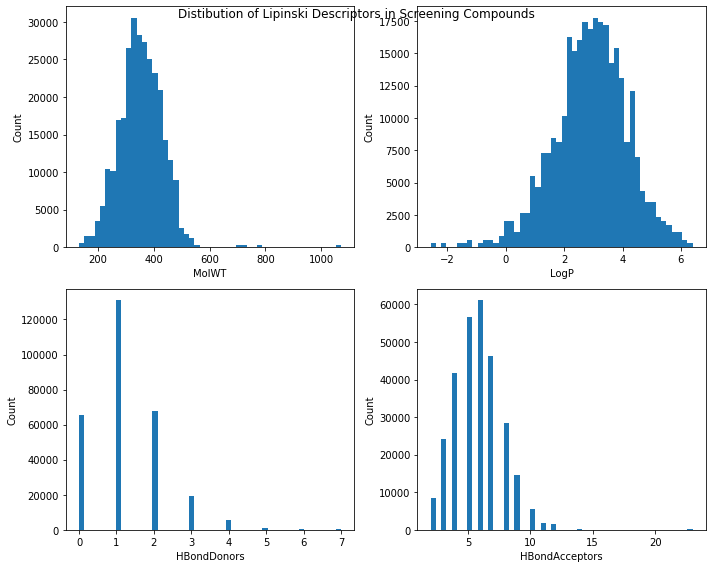

In [13]:
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (10,8))
fig.suptitle('Distibution of Lipinski Descriptors in Screening Compounds')

for i,j in zip([ax1, ax2, ax3, ax4], physchem_features.columns):
    i.hist(physchem_features[j], bins = 50)
    i.set_xlabel(j)
    i.set_ylabel('Count')
    
plt.tight_layout()
plt.show()

## Scaffolds

Scaffolds of compounds are underlying structural elements of a compound that can be used to identify similarities between compounds based on shape alone. Detecting scaffolds was introduced by [**Murcko and Bemis (1996)**](https://pubs.acs.org/doi/10.1021/jm9602928) to find similarities between approved drugs. Grouping compounds by a common scaffold is useful......

[**Murcko and Bemis (1996)**](https://pubs.acs.org/doi/10.1021/jm9602928) categorize structural features of molecules into four categories:
* **Ring Systems:** cycles and fused cycles
* **Linker Atoms:** atoms in the direct path between rings
* **Side Chain Atoms:** any non-ring and non-linker atoms
* **FrameWork =** **Ring systems** + **Linker atoms**

The scaffold is the framework. In this section, we'll look at the most popular scaffolds in our dataset. ```rdkit.Chem.PandasTools``` has a function that will generate the smiles of a scaffold

,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,Structure,Scaffold
90,Inactive,0.0,,
431,Inactive,1.0,,
103,Inactive,0.0,,

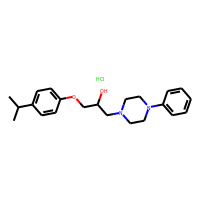
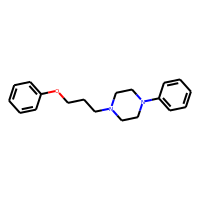
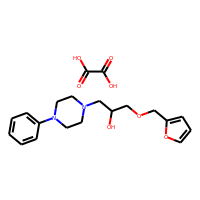
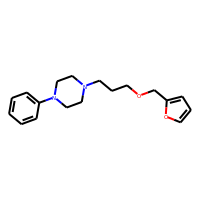
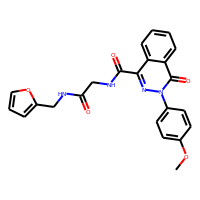
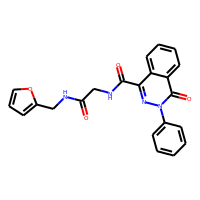

In [14]:
PandasTools.AddMurckoToFrame(df_sample, molCol = 'Structure', MurckoCol='Scaffold smiles')
PandasTools.AddMoleculeColumnToFrame(df_sample, smilesCol='Scaffold smiles',molCol='Scaffold')
df_sample[['PUBCHEM_ACTIVITY_OUTCOME', 'PUBCHEM_ACTIVITY_SCORE','Structure','Scaffold']][0:3]

In [15]:
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmilesFromSmiles


start_timer = time.time()

scaffolds = multiprocess(df['smiles'], MurckoScaffoldSmilesFromSmiles)

stop_timer = time.time()

print(f'{round(stop_timer - start_timer)} s to apply function to {len(df)} cells')

58 s to apply function to 290893 cells


,smiles,count,ROMol
0,c1ccccc1,7273,
1,C1C2CC3CC1CC(C2)C3,873,
2,O=S(=O)(NCc1ccccc1)c1ccccc1,873,
3,O=C(Nc1ccccc1)c1ccccc1,873,
4,O=C(COc1ccccc1)Nc1ccccc1,872,

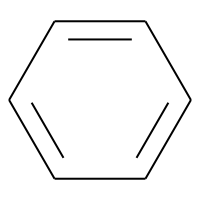
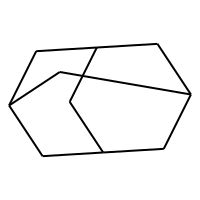
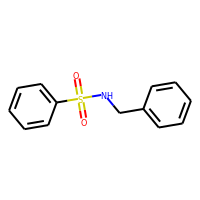
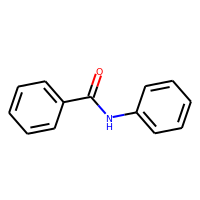
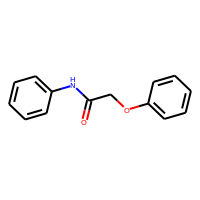

In [16]:
scaffold_counts = scaffolds[0].value_counts().reset_index()
scaffold_counts.columns = ['smiles','count']
PandasTools.AddMoleculeColumnToFrame(scaffold_counts, smilesCol = 'smiles')
scaffold_counts.nlargest(5, 'count')

## Fragments and Fingerprints 

As well as calculating physical properties of our molecules, we can also search for the presence of any given sub-strucuture. Sub-structure searching (SSS) can be used to interrogate a dataset,  generate molecular features for a model and indentify similar compounds. Given it's usefulness, SSS is a core concept of cheminformatics.

SSS is a [**graph isomorphism**](https://en.wikipedia.org/wiki/Graph_isomorphism) problem, where here *graph* refers to a network of **nodes** (atoms) and **edges** (bonds). In [**graph theory**](https://en.wikipedia.org/wiki/Graph_theory), a [**graph**](https://en.wikipedia.org/wiki/Graph_(discrete_mathematics)) is a data structure that contains objects (nodes) and relationships between them (edges). Nodes and edges contain information about items and the relationship between them. *Graphs* are a data structure that used to describe:

|**Graph**|**Nodes**|**Edges**|
|----|-----|----|
|Molecules|Atoms|Bonds|
|Protein Structures|Amino acids|Contacts|
|Metabolic networks|Compounds|Enzyme transformations|
|Social networks|People|Friendship|
|Street maps|Intersections|Roads|

Graphs are as a common data structure in the biosciences as other fields, and to navigate and extract information from them, we have plenty of [**algorithms**](https://en.wikipedia.org/wiki/Graph_theory#Algorithms) at our disposal. SSS, however is an [**NP-complete problem**](https://en.wikipedia.org/wiki/NP-completeness), a term which in [**computational complexity theory**](https://en.wikipedia.org/wiki/Computational_complexity_theory) is given to problems that must be solved by systematically ----------

First, we'll look at searching for a set of sub-structures in a given molecule. Below I've made a function that builds an ```rdkit molecule``` from an input smiles string, and a set of query ```rdkit molecules``` from a user-provided list. Importantly, the search is function is restricted to searching for fragments that be expressed with a valid smiles string. ```rdkit molecules``` have a sub-structure search fucntion ```mol.HasSubstructMatch(x)``` where x is the query molecule. ```HasSubstructMatch``` returns ```True``` or ```False```, which can be binarized using 
```python
int(True) = 1
int(False) = 0
```

Functions that return a ```pandas .Series()``` object, when mapped/applied to the column of a ```Dataframe```, will return another ```DataFrame```.

In [17]:
hand_crafted_features = ['NC(=S)N', 'NC(=O)','[N+](=O)[O-]']

def SubstructureMatch(smiles, list_of_substructures):
    mol = Chem.MolFromSmiles(smiles)
    features = [Chem.MolFromSmiles(i) for i in list_of_substructures]
    matches = [mol.HasSubstructMatch(i) for i in features]
    matches = pd.Series(dict(zip(list_of_substructures, matches)))
    return matches

df_sample['smiles'].apply(SubstructureMatch,args=[hand_crafted_features]).head()

,NC(=S)N,NC(=O),[N+](=O)[O-]
90,False,False,False
431,False,False,False
103,False,True,False
267,False,True,False
70,False,True,False


### Bags of Fragments

```RDKit``` has a specialised fragment searching module: [```rdkit.Chem.Fragments```](https://www.rdkit.org/docs/source/rdkit.Chem.Fragments.html), which contains functions for searching for specific framents, e.g.
```python
mesotrione = rdkit.Chem.MolFromSmiles('CS(=O)(=O)c1ccc(c(c1)[N+](=O)[O-])C(=O)C2C(=O)CCCC2=O')
rdkit.Chem.Fragments.fr_C_O_noCOO(mesotrione)
```

Below I've made a function that uses ```dict(Fragments.fns) ``` to contain all available fragment searching functions and their names, and then applies each one to the ```mol``` generated from the input smiles. Unlike the SSS function we used above, this one counts the occurence of each fragment, which is more informative than boolean output we had before.

### -----Adding custom fragment files--------

In [18]:
from rdkit.Chem import Fragments

# fragment files

def RDKitBagOfFeatures(smiles):
    mol = Chem.MolFromSmiles(smiles)
    frag_fns = dict(Fragments.fns)
    frag_matches = dict(zip(frag_fns.keys(), 
                     [i(mol) for i in frag_fns.values()]))

    return pd.Series(frag_matches)

df_sample['smiles'].apply(RDKitBagOfFeatures).head()

,fr_C_O,fr_C_O_noCOO,fr_Al_OH,fr_Ar_OH,fr_methoxy,fr_oxime,fr_ester,fr_Al_COO,fr_Ar_COO,fr_COO,...,fr_benzodiazepine,fr_para_hydroxylation,fr_allylic_oxid,fr_aryl_methyl,fr_Ndealkylation1,fr_Ndealkylation2,fr_alkyl_carbamate,fr_ketone_Topliss,fr_ArN,fr_HOCCN
90,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
431,2,0,1,0,0,0,0,2,0,2,...,0,1,0,0,0,0,0,0,0,1
103,2,2,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
267,1,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
70,1,1,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0


## Fingerprints

Mol:	COC1=CC(=C(C=C1)N2C(=O)C3=CC=CC=C3NC2=O)OC
<class 'rdkit.DataStructs.cDataStructs.ExplicitBitVect'>
Number of bits: 512
Bits on: 39


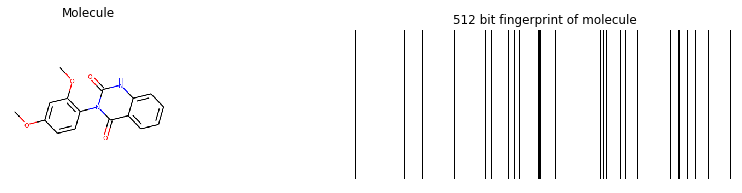

In [23]:
from rdkit.Chem import rdMolDescriptors, Draw

sampled_smiles = df['smiles'].sample().item()
mol = Chem.MolFromSmiles(sampled_smiles)
fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2,nBits=512)

print(f'Mol:\t{sampled_smiles}')
print(type(fp))
print(f'Number of bits: {(len(fp))}')
print(f'Bits on: {len(fp.GetOnBits())}')


fig, ((ax1, ax2)) = plt.subplots(1,2, figsize = (15,3))

ax1.imshow(Draw.MolToImage(mol))
ax1.axis('off')
ax1.set_title('Molecule')

fp_array = np.array([not fp.GetBit(i) for i in range(fp.GetNumBits())]).astype(int).reshape(1,-1)
plt.set_cmap('gray')
ax2.imshow(fp_array, aspect = 200)
ax2.axis('off')
ax2.set_title('512 bit fingerprint of molecule')
plt.show()

In [24]:
bit_info = {}
fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, bitInfo=bit_info)
on_bits = list(fp.GetOnBits())
for i in on_bits[0:4]:
    print(f'Bit: {i} \t Info: {bit_info[i]}')

Bit: 119 	 Info: ((16, 1),)
Bit: 221 	 Info: ((18, 2),)
Bit: 249 	 Info: ((20, 2),)
Bit: 314 	 Info: ((10, 1), (19, 1))


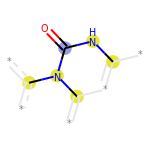

In [27]:
Draw.DrawMorganBit(mol, 221,bit_info)

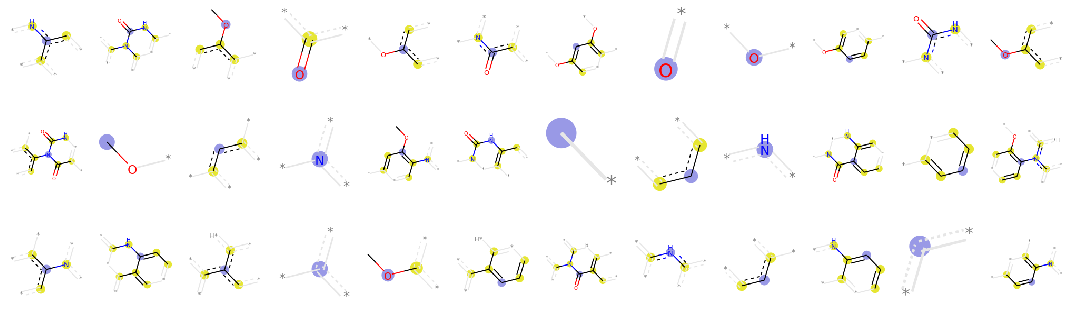

In [25]:
fig, axes = plt.subplots(3,12, figsize=(15,5))
for bit,ax in zip(on_bits, axes.flatten()):
    ax.imshow(Draw.DrawMorganBit(mol, bit,bit_info),
             interpolation='none')
    ax.axis('off')

plt.tight_layout()
plt.show()